### Further wrangle with the features 

In [1]:
import time
import datetime
import copy
import numpy as np
import math

import pandas as pd
import json
from bson.json_util import dumps
from fastparquet import ParquetFile,write
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
pf=ParquetFile('full_2nd_events4ml_110419.parq')

In [5]:
udf=pf.to_pandas()

In [6]:
udf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38186 entries, 11049447 to 9968570
Data columns (total 24 columns):
category                 38186 non-null int64
past                     38186 non-null int32
votes                    38186 non-null int64
is_eventbrite            38186 non-null int32
is_free                  38186 non-null int32
doors                    38186 non-null int32
sold_out                 38186 non-null int32
venue.id                 38186 non-null int64
venue.popularity         38186 non-null float64
venue.zip                38186 non-null int64
ticket_allages           38186 non-null int32
ticket_price_low         38186 non-null float64
ticket_price_max         38186 non-null float64
min_age                  38186 non-null int32
artist.popularity.sum    38186 non-null float64
artist.popularity.avg    38186 non-null float64
artist.popularity.max    38186 non-null float64
dow                      38186 non-null int64
doy                      38186 non-null in

In [2]:
pf=ParquetFile('do512_10-3-2019-10-3-2018.parquet')
df2=pf.to_pandas()

In [3]:
df2.columns.values

array(['id', 'permalink', 'presented_by', 'title', 'description',
       'excerpt', 'category', 'category_param',
       'conference_category_param', 'begin_time',
       'tz_adjusted_begin_date', 'tz_adjusted_end_date', 'begin_date',
       'past', 'end_date', 'end_time', 'votes', 'ticket_info',
       'allstar_votes', 'is_lens', 'is_eventbrite', 'amazon_affiliate',
       'eventbrite_id', 'ticket_onsale_time', 'tickets_onsale_today',
       'is_free', 'is_ongoing', 'rating', 'doors', 'popularity',
       'sold_out', 'favorite', 'artists', 'rsvp', 'buy_url', 'eager',
       'imagery.photo', 'imagery.poster',
       'imagery.aws.cover_image_w_1200_h_450',
       'imagery.aws.cover_image_h_300_w_864',
       'imagery.aws.cover_image_h_250_w_680',
       'imagery.aws.cover_image_h_630_w_1200',
       'imagery.aws.cover_image_h_50_w_50', 'tracking.impression',
       'tracking.hover', 'tracking.click', 'tracking_urls.impression',
       'tracking_urls.hover', 'tracking_urls.click', 'actio

In [119]:
df2=df2[['title','venue.id', 'venue.title','venue.address',
       'venue.city', 'venue.state', 'venue.zip','venue.latitude','venue.longitude','tz_adjusted_begin_date', 'tz_adjusted_end_date','id']]

In [120]:
df2=df2.drop_duplicates(subset='id')

#### Parse the information of event address

In [125]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40703 entries, 0 to 41864
Data columns (total 12 columns):
title                     40703 non-null object
venue.id                  40703 non-null int64
venue.title               40703 non-null object
venue.address             39923 non-null object
venue.city                39997 non-null object
venue.state               39997 non-null object
venue.zip                 39923 non-null object
venue.latitude            34020 non-null float64
venue.longitude           34021 non-null float64
tz_adjusted_begin_date    40703 non-null object
tz_adjusted_end_date      40703 non-null object
id                        40703 non-null int64
dtypes: float64(2), int64(2), object(8)
memory usage: 4.0+ MB


In [126]:
## fix all kinds of the 'austin' back to 'Austin'
rep=['AUSTIN','Ausitn','Austin ','AUSTIN ','Austin TX','78701','Austin,','Austin, ','Austin, TX','austin',' Austin','Austi',' AUSTIN']
df2.loc[df2['venue.city'].isin(rep),'venue.city']='Austin'

In [127]:
# include only specific cities/counties
incities=['Austin','Round Rock','Cedar Park','Pflugerville','Leander','Spicewood','West Lake Hills','Westlake Hills',' Round Rock',' Round Rock','Leander ','Bee cave','Bee Cave']

In [128]:
# fix some more city names
rep2=[' Round Rock']
df2.loc[df2['venue.city'].isin(rep2),'venue.city']='Round Rock'
rep2=['Leander ']
df2.loc[df2['venue.city'].isin(rep2),'venue.city']='Leander'
rep2=['Bee cave']
df2.loc[df2['venue.city'].isin(rep2),'venue.city']='Bee Cave'
rep2=['Westlake Hills']
df2.loc[df2['venue.city'].isin(rep2),'venue.city']='West Lake Hills'

In [129]:
df2.loc[df2['venue.city'].isin(incities)]['venue.city'].value_counts()

Austin             37370
Round Rock           293
Cedar Park           230
Pflugerville         139
Bee Cave              60
Leander               42
Spicewood             38
West Lake Hills       14
Name: venue.city, dtype: int64

In [130]:
len(df2)

40703

In [131]:
# build a mask based on cities to exclude non-greater-Austin events
mask=df2['venue.city'].isin(incities)
# first mask the original df for such events
#udf=udf[mask.values]

In [132]:
df2=df2[mask]

In [133]:
print("after masking:",len(udf),len(df2))

after masking: 32880 38186


In [134]:
df2.columns.values[0:-1]

array(['title', 'venue.id', 'venue.title', 'venue.address', 'venue.city',
       'venue.state', 'venue.zip', 'venue.latitude', 'venue.longitude',
       'tz_adjusted_begin_date', 'tz_adjusted_end_date'], dtype=object)

In [145]:
# join back the columns to udf
for item in df2.columns.values[0:-1]:
    udf[item]=df2[item].values

In [79]:
#  check the 'secret locations' > to take out all secrete location events
dump = df2['venue.address'].values

In [136]:
mask3= []
secrets = []
for i,item in enumerate(dump):
    if item:
        if 'secret' in item: 
            print(item)
            secrets+=[item]
        mask3+=[True]
    else:
        mask3+=[False]

In [137]:
print("total events with address:",sum(mask3),"out of:",len(df2), "events.")
print("total number of events in secret locations:",len(secrets))

total events with address: 37975 out of: 38186 events.
total number of events in secret locations: 0


In [138]:
# filter out the no address locations, first display
a=pd.Series(mask3)
df2[list(~a)]['venue.title'].value_counts()

Austin                                      74
The Museum of Human Achievement             36
TBA                                         29
Lady Bird Lake                              11
All Austin Area Pluckers                     8
Barton Creek Greenbelt                       6
All Austin Area Cover 3                      5
Lake Travis                                  4
All Austin Area Lick Honest Ice Creams       4
Mueller Austin                               4
Gender and Sexuality Center                  3
6th Street                                   2
Fox 7 - Good Day Austin                      2
Austin Sports and Social Club                2
All Austin Area P. Terrys                    2
All Lavaca Street Bar Locations              2
2511 Diaz Street                             2
Auditorium Shores & Republic Square Park     2
All Austin Area Houndstooth Coffee           1
We Are Blood Donor Centers                   1
Bird Barn                                    1
West Campus  

In [139]:
# eliminate the ones without lat/lon 
check = df2['venue.latitude'].values
#mask4= [True for x in list(check) if x!=np.nan else False ]

In [140]:
mask4=[]
for item in check:
    if np.isnan(item):
        mask4+= [False]
    else: mask4+=[True]

In [142]:
df2=df2[mask4]

In [143]:
print("total number of event locations with lat/lon information:",sum(mask4),"out of :",len(df2))
print("proportion of events not with lat/lon:",(len(df2)-sum(mask4))/len(df2)*100,"%")

total number of event locations with lat/lon information: 32880 out of : 32880
proportion of events not with lat/lon: 0.0 %


In [86]:
udf=udf[mask4]

In [147]:
udf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32880 entries, 11049447 to 9968570
Data columns (total 33 columns):
category                  32880 non-null int64
past                      32880 non-null int32
votes                     32880 non-null int64
is_eventbrite             32880 non-null int32
is_free                   32880 non-null int32
doors                     32880 non-null int32
sold_out                  32880 non-null int32
venue.id                  32880 non-null int64
venue.popularity          32880 non-null float64
venue.zip                 32806 non-null object
ticket_allages            32880 non-null int32
ticket_price_low          32880 non-null float64
ticket_price_max          32880 non-null float64
min_age                   32880 non-null int32
artist.popularity.sum     32880 non-null float64
artist.popularity.avg     32880 non-null float64
artist.popularity.max     32880 non-null float64
dow                       32880 non-null int64
doy                    

In [148]:
from scipy.stats import skew, skewtest
print("skewness of target votes:",skew(udf['votes']))
print("skew test:",skewtest(udf['votes']))

skewness of target votes: 40.05724228208327
skew test: SkewtestResult(statistic=277.3458192023687, pvalue=0.0)


In [28]:
# filter down to total number of events with good location info
udf=udf[mask4]

In [149]:
print("after masking:",len(udf),len(mask4))

after masking: 32880 38186


### Check the distribution of the votes(target)

Text(0, 0.5, 'event counts')

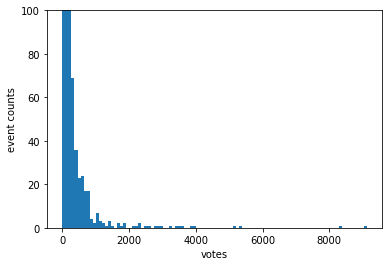

In [90]:
# plot the votes distribution after cleanup of cities
# plot votes distribution for all data
n_bins = 100
x=udf.votes.values
# subset votes to those not 1
xx = [c for c in x if c>0]
fig = plt.hist(xx,bins=n_bins)
plt.ylim([0,100])
plt.xlabel('votes')
plt.ylabel('event counts')
#plt.xlim([1000,9000])

In [91]:
# saveout data
write('full_3rd_eventfeatures_110519.parq',udf)

In [93]:
pd.set_option('display.max_columns', 999)

In [217]:
view=udf.sort_values(by=['votes'],ascending=False)

In [218]:
udf.columns

Index(['category', 'past', 'votes', 'is_eventbrite', 'is_free', 'doors',
       'sold_out', 'venue.id', 'venue.popularity', 'venue.zip',
       'ticket_allages', 'ticket_price_low', 'ticket_price_max', 'min_age',
       'artist.popularity.sum', 'artist.popularity.avg',
       'artist.popularity.max', 'dow', 'doy', 'month', 'day', 'hour',
       'venue.tol_num_events', 'ev_id', 'title', 'venue.title',
       'venue.address', 'venue.city', 'venue.state', 'venue.latitude',
       'venue.longitude', 'tz_adjusted_begin_date', 'tz_adjusted_end_date'],
      dtype='object')

In [219]:
view=view[['category','votes',
       'sold_out','artist.popularity.sum','dow', 'doy', 'month', 'day', 'hour',
       'venue.tol_num_events','title', 'venue.title','tz_adjusted_begin_date', 'tz_adjusted_end_date']]

In [257]:
print("showing the top 1%:",len(view)*0.01)
print("top events:there are ",len(view.loc[view['votes']>8000]), "events with votes >8000")
print("top events:there are ",len(view.loc[view['votes']>5000]), "events with votes >5000")
print("top events:there are ",len(view.loc[view['votes']>1000]), "events with votes >1000")
print("top events:there are ",len(view.loc[view['votes']>500]), "events with votes >500")
print("top events:there are  ",len(view.loc[view['votes']>200]), "events with votes >200")

showing the top 1%: 328.8
top events:there are  2 events with votes >8000
top events:there are  4 events with votes >5000
top events:there are  41 events with votes >1000
top events:there are  118 events with votes >500
top events:there are   381 events with votes >200


In [194]:
view.loc[view['votes']>500]

,category,votes,sold_out,artist.popularity.sum,dow,doy,month,day,hour,venue.tol_num_events,title,venue.title,duration,duration_day
id,,,,,,,,,,,,,,
8604612,0,9120,0,4478328.0,4,278,10,5,11,38,Weekend One: ACL Music Festival ft. Paul McCar...,Zilker Park,63.00,True
8604644,0,8350,0,4353930.0,4,285,10,12,11,38,Weekend Two: ACL Music Festival ft. Paul McCar...,Zilker Park,63.00,True
9336463,0,5366,0,6263.0,5,40,2,9,19,50,An Evening with Fleetwood Mac,Frank Erwin Center,7.00,False
9336440,10,5176,0,0.0,4,292,10,19,9,27,Formula 1 Pirelli 2018 United States Grand Prix,Circuit of the Americas,65.00,True
8999040,1,3959,0,48.0,4,306,11,2,19,50,The Kevin Hart Irresponsible Tour,Frank Erwin Center,7.00,False
10372327,0,3842,0,73238.0,0,42,2,11,21,460,"Gary Clark Jr. ""This Land"" Album Preview with ...",Antone's,4.25,False
10351666,0,3621,0,118752.0,0,70,3,11,13,481,"Strange Brew VIII ft. Oh Sees, Annabelle Chair...",Hotel Vegas,13.00,False
10433125,0,3504,0,96908.0,5,68,3,9,20,460,"Capital One House Day Two ft. CHVRCHES, Jade B...",Antone's,4.00,False
10351680,0,3382,0,847.0,5,75,3,16,11,387,"The Big One ft. Abhi The Nomad, Durand Jones &...",Barracuda,6.50,False


In [233]:
# save for examine : Pri
k=view.loc[view['votes']>500]
k.to_csv('top_events_rate_by_votes.csv')

In [156]:
# create a multi-days column for events

In [220]:
udf['tz_adjusted_begin_date']=pd.to_datetime(udf['tz_adjusted_begin_date'])
udf['tz_adjusted_end_date']=pd.to_datetime(udf['tz_adjusted_end_date'])

ValueError: Tz-aware datetime.datetime cannot be converted to datetime64 unless utc=True

In [221]:
view['duration']=(view['tz_adjusted_end_date']-view['tz_adjusted_begin_date']).apply(lambda x:x/ np.timedelta64(1, 'h'))

In [222]:
view['duration_day']=view['duration'].apply(lambda x:np.ceil(x/24))

In [223]:
a=view['duration'].values/24
multid=[True if x >=1 else False for x in a]

In [229]:
view['multiday']=multid
view['avg_votes_pday']=view['votes']/view['duration_day']

In [225]:
# fix duration_day=0
view=view.replace({'duration':0},2)
view=view.replace({'duration_day':0},1)

In [226]:
view.drop(columns=['tz_adjusted_begin_date','tz_adjusted_end_date'],inplace=True)

In [227]:
# check multiday events
# rearrange columns
usecols = ['multiday','title','votes','avg_votes_pday','venue.title','duration','duration_day','artist.popularity.sum','dow','month','day','hour']
view=view[usecols]
multid_df=view[view['multiday'].values]

In [230]:
view.sort_values(by=['avg_votes_pday'],ascending=False)

,multiday,title,votes,avg_votes_pday,venue.title,duration,duration_day,artist.popularity.sum,dow,month,day,hour
id,,,,,,,,,,,,
9336463,False,An Evening with Fleetwood Mac,5366,5366.000000,Frank Erwin Center,7.000000,1.0,6263.0,5,2,9,19
8999040,False,The Kevin Hart Irresponsible Tour,3959,3959.000000,Frank Erwin Center,7.000000,1.0,48.0,4,11,2,19
10372327,False,"Gary Clark Jr. ""This Land"" Album Preview with ...",3842,3842.000000,Antone's,4.250000,1.0,73238.0,0,2,11,21
10351666,False,"Strange Brew VIII ft. Oh Sees, Annabelle Chair...",3621,3621.000000,Hotel Vegas,13.000000,1.0,118752.0,0,3,11,13
10433125,False,"Capital One House Day Two ft. CHVRCHES, Jade B...",3504,3504.000000,Antone's,4.000000,1.0,96908.0,5,3,9,20
10351680,False,"The Big One ft. Abhi The Nomad, Durand Jones &...",3382,3382.000000,Barracuda,6.500000,1.0,847.0,5,3,16,11
10351657,False,"Galactic Interactive ft. Blackillac, Blood Cul...",3273,3273.000000,Hotel Vegas,7.500000,1.0,1782.0,4,3,8,18
8604612,True,Weekend One: ACL Music Festival ft. Paul McCar...,9120,3040.000000,Zilker Park,63.000000,3.0,4478328.0,4,10,5,11
10261678,False,"Levitation Day Party ft. Oh Sees, Chai, Amyl &...",2990,2990.000000,Hotel Vegas,5.000000,1.0,1166.0,3,3,14,14


In [250]:
top10=view.iloc[0:10,:]
top100=view.iloc[11:100,:]
top500=view.iloc[101:500,:]
top1000=view.iloc[501:1000,:]
print("total number of multiday events:",sum(view['multiday'].values))
print("percentage multiday events in top10:",sum(top10['multiday'].values)/sum(view['multiday'].values)*100,"%",sum(top10['multiday'].values),"out of 10")
print("percentage multiday events in top100:",sum(top10['multiday'].values)/sum(view['multiday'].values)*100,"%",sum(top100['multiday'].values),"out of 89")
print("percentage multiday events in top500:",sum(top500['multiday'].values)/sum(view['multiday'].values)*100,"%",sum(top500['multiday'].values),"out of 399")
print("percentage multiday events in top1000:",sum(top1000['multiday'].values)/sum(view['multiday'].values)*100,"%",sum(top1000['multiday'].values),"out of 499")

total number of multiday events: 367
percentage multiday events in top10: 0.8174386920980926 % 3 out of 10
percentage multiday events in top100: 0.8174386920980926 % 9 out of 89
percentage multiday events in top500: 2.997275204359673 % 11 out of 399
percentage multiday events in top1000: 2.7247956403269753 % 10 out of 499


In [253]:
top1000all=view.iloc[0:1000,:]

In [256]:
sum(top1000all['multiday'].values)/1000*100

3.3000000000000003

In [266]:
# populate udf with the duration, multi-day or not and average daily votes
udf['duration']=(udf['tz_adjusted_end_date']-udf['tz_adjusted_begin_date']).apply(lambda x:x/ np.timedelta64(1, 'h'))
udf['duration_day']=udf['duration'].apply(lambda x:np.ceil(x/24))

In [268]:
a=udf['duration'].values/24
multid=[True if x >=1 else False for x in a]
udf['multiday']=multid
udf=udf.replace({'duration':0},2)
udf=udf.replace({'duration_day':0},1)
udf.drop(columns=['tz_adjusted_begin_date','tz_adjusted_end_date'],inplace=True)

In [270]:
udf['avg_votes_pday']=udf['votes']/udf['duration_day']

In [271]:
udf.head()

,category,past,votes,is_eventbrite,is_free,doors,sold_out,venue.id,venue.popularity,venue.zip,ticket_allages,ticket_price_low,ticket_price_max,min_age,artist.popularity.sum,artist.popularity.avg,artist.popularity.max,dow,doy,month,day,hour,venue.tol_num_events,ev_id,title,venue.title,venue.address,venue.city,venue.state,venue.latitude,venue.longitude,duration,duration_day,multiday,avg_votes_pday
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11049447,0,0,784,0,0,1,0,113,15.0,78701,1,0.0,0.0,0,73238.0,73238.0,73238.0,3,276,10,3,19,377,11049447,Gary Clark Jr,Stubb's,801 Red River,Austin,TX,30.268458,-97.736175,7.0,1.0,False,784.0
11049456,0,0,223,0,0,1,0,175439,15.0,78741,0,0.0,0.0,18,101.0,101.0,101.0,3,276,10,3,20,116,11049456,Hippie Sabotage w/ Sebastian Paul,Emo's,2015 E. Riverside Dr.,Austin,TX,30.240266,-97.728516,6.0,1.0,False,223.0
11049430,0,0,163,0,0,1,0,654,15.0,78702,1,0.0,0.0,0,3770.0,1885.0,1885.0,3,276,10,3,18,237,11049430,FIDLAR w/ XETAS,Historic Scoot Inn,1308 E. Fourth,Austin,TX,30.262141,-97.729385,7.5,1.0,False,163.0
11141496,1,0,126,1,0,1,0,302617,1.0,78701,0,10.0,12.0,0,0.0,0.0,0.0,3,276,10,3,19,244,11141496,Hear Me Bitch 90’s Birthday Bash Comedy Show,Fallout Theater,616 Lavaca St,Austin,TX,30.269536,-97.745230,6.5,1.0,False,126.0
11109390,1,0,83,0,1,0,0,3519,1.0,78702,0,0.0,0.0,0,98.0,14.0,14.0,3,276,10,3,21,85,11109390,Brixton Comedy Hour,The Brixton,1412 E. 6th Street,Austin,TX,30.263590,-97.727604,5.0,1.0,False,83.0


In [272]:
# save back to another dataset
write('full_3rd_eventfeatures_110619.parq',udf)